In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [6]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
    fit_uncertainties_and_remove_outliers,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from sklearn.decomposition import TruncatedSVD

In [5]:
from POSEIDON.utility import read_high_res_data
import h5py

data = h5py.File("/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-121.h5", "a")

In [9]:
for chip in ["redl", "redu"]:
    flux = data[chip]["flux"][:]
    N_order, N_phi, N_wl = flux.shape
    continuum = np.zeros((N_order, N_phi, N_wl))
    for k in range(N_order):
        order = flux[k]

        middle = np.median(order, axis=0)
        order_norm = order / middle

        continuum[k] = order_norm

    for det in range(N_order):
        for phi in range(N_phi):
            continuum[det][phi] = median_filter(continuum[det][phi], size=501)

    for det in range(N_order):
        for phi in range(N_phi):
            continuum[det][phi] = gaussian_filter1d(continuum[det][phi], sigma=100)

    flux_blaze_corrected = flux / continuum

    data[chip]["flux_blaze_corrected"][:] = flux_blaze_corrected

    uncertainties = fit_uncertainties(flux_blaze_corrected)

    flux_filterd = np.zeros_like(flux_blaze_corrected)
    N_order, N_phi, N_wl = flux_blaze_corrected.shape

    for i in range(N_order):
        uncertainties[i] = uncertainties[i] / np.median(flux_blaze_corrected[i], axis=0)
        flux_blaze_corrected[i] = flux_blaze_corrected[i] / np.median(
            flux_blaze_corrected[i], axis=0
        )
        pca = TruncatedSVD(n_components=10).fit(flux_blaze_corrected[i])
        PCAs = pca.transform(flux_blaze_corrected[i]) @ pca.components_
        uncertainties[i] = uncertainties[i] / PCAs
        flux_filterd[i] = flux_blaze_corrected[i] / PCAs

    data[chip]["residuals"][:] = flux_filterd
    data[chip]["uncertainties"][:] = uncertainties
data.close()

3.162475658545312 252.12250645224992
2.8863097126999735 274.21045201338137
2.2494507080508743 302.42067622749187
1.5502196806149744 350.9061759795742
1.0281078050781536 391.51614708166625
0.681296414232754 428.08181382443985
0.4073898650728004 466.5596754838068
0.36379800656694883 477.59757890564697
0.2942309619654074 502.61085665746236
0.2820317710882573 510.5003452043595
0.3376924246164783 502.2640565744798
0.32025523213352747 506.0815814198192
0.3593321158460246 451.6179901193833
0.33509122009310394 436.2377974792985
0.3538738376075312 426.986902520245
0.37594227862022683 414.49029042188033
0.3781594665862677 418.6852727420073
0.3870790653432564 411.07884727240224
0.3879605141809079 411.3593582195389
0.38829030019190347 414.1931676310057
0.3879377105006525 414.69507098151047
0.3783478340310453 421.48635641835574
0.3815126853581812 421.6997550880393
0.39049951653981096 415.911647872759
0.3824305769058131 426.7900619446116
0.4001361138629997 432.2728649303784
0.3917541388821407 912.22

In [15]:
data = h5py.File("/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-121.h5", "a")

In [16]:
data["redl"]["residuals"][:] = data["redl"]["residuals"][:] - 1
data["redu"]["residuals"][:] = data["redu"]["residuals"][:] - 1

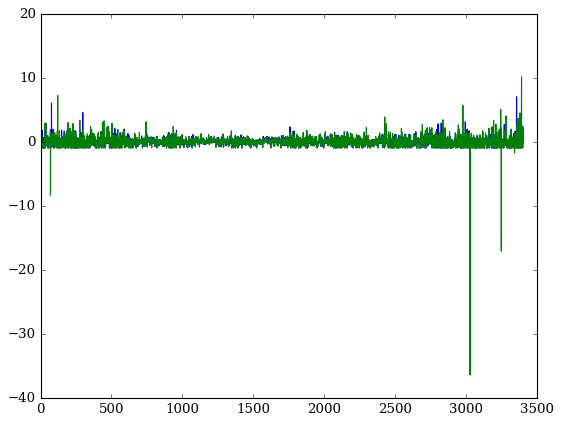

In [18]:
plt.plot(data["redl"]["residuals"][:][0, 0])
plt.plot(data["redl"]["residuals_2020"][:][0, 0])

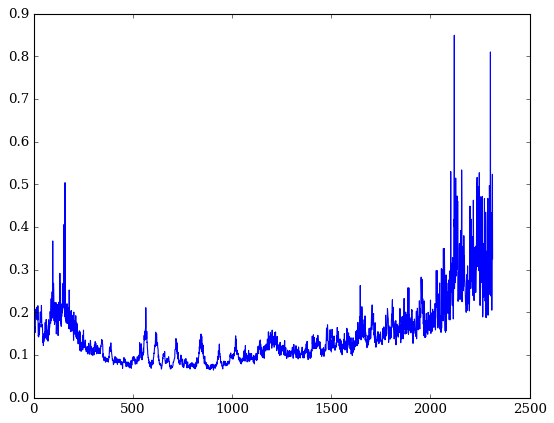

In [8]:
plt.plot(data["blue"]["uncertainties"][:][0, 0])